In [17]:
%pip install optuna  

Note: you may need to restart the kernel to use updated packages.


In [18]:
"""
DYNAMIC TRIP RESCHEDULING WITH BAYESIAN OPTIMIZATION
====================================================
Multi-driver cascading reassignment with CP-SAT and Bayesian Optimization
"""

# ============================================================================
# SETUP
# ============================================================================

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our modules with error handling
try:
    from models.driver_state import DriverState, DailyAssignment
    print("✅ Models imported")
except ImportError as e:
    print(f"❌ Error importing models: {e}")
    raise

try:
    from evaluation_metrics import OptimizationMetrics, MetricsCalculator
    print("✅ Evaluation metrics imported")
except ImportError as e:
    print(f"❌ Error importing evaluation_metrics: {e}")
    raise

try:
    from opt.candidate_gen_v2 import CandidateGeneratorV2
    from opt.cpsat_model_v2 import CPSATOptimizer
    print("✅ Optimization modules imported")
except ImportError as e:
    print(f"❌ Error importing optimization modules: {e}")
    raise

try:
    from opt.bayesian_tuner import BayesianOptimizationTuner
    print("✅ Bayesian tuner imported")
except ImportError as e:
    print(f"⚠️  Warning: Could not import Bayesian tuner: {e}")
    print("   Will use fallback random search")
    BayesianOptimizationTuner = None

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("🚛 DYNAMIC TRIP RESCHEDULING SYSTEM")
print("=" * 50)

# ============================================================================
# 1. LOAD DATA
# ============================================================================

print("\n📊 LOADING DATA")
print("-" * 40)

df_trips = pd.read_csv("../data/processed/trips.csv", parse_dates=['od_start_time', 'od_end_time'])
df_routes = pd.read_csv("../data/processed/routes.csv", parse_dates=['route_start_time', 'route_end_time'])

print(f"✅ Loaded {len(df_trips):,} trips")
print(f"✅ Loaded {len(df_routes):,} routes")
print(f"✅ Date range: {df_trips['od_start_time'].min().date()} to {df_trips['od_start_time'].max().date()}")


✅ Models imported
✅ Evaluation metrics imported
✅ Optimization modules imported
✅ Bayesian tuner imported
🚛 DYNAMIC TRIP RESCHEDULING SYSTEM

📊 LOADING DATA
----------------------------------------
✅ Loaded 14,817 trips
✅ Loaded 1,504 routes
✅ Date range: 2018-09-12 to 2018-10-04


In [19]:

# ============================================================================
# 2. INITIALIZE DRIVER STATES
# ============================================================================

print("\n🔧 INITIALIZING DRIVER STATES")
print("-" * 40)

driver_states = {}

# Create DriverState for each unique driver
for _, route in df_routes.iterrows():
    driver_id = route['route_schedule_uuid']
    
    # Get all trips for this driver
    driver_trips = df_trips[df_trips['route_schedule_uuid'] == driver_id].copy()
    
    if len(driver_trips) > 0:
        driver_state = DriverState(driver_id=driver_id, route_id=driver_id)
        
        # Add assignments
        for _, trip in driver_trips.iterrows():
            date_str = trip['od_start_time'].strftime('%Y-%m-%d')
            
            assignment = DailyAssignment(
                trip_id=trip['trip_uuid'],
                start_time=trip['od_start_time'],
                end_time=trip['od_end_time'],
                duration_minutes=int(trip['trip_duration_minutes']),
                start_location=str(trip['source_center']),
                end_location=str(trip['destination_center'])
            )
            
            driver_state.add_assignment(date_str, assignment)
        
        driver_states[driver_id] = driver_state

print(f"✅ Initialized {len(driver_states)} driver states")

# Show driver utilization (with error handling for different DriverState implementations)
try:
    # Try to get utilization summary
    sample_summary = list(driver_states.values())[0].get_utilization_summary() if driver_states else {}
    
    # Check what keys are available and use them
    if 'total_capacity_used_hours' in sample_summary:
        total_capacity_used = sum(d.get_utilization_summary()['total_capacity_used_hours'] 
                                 for d in driver_states.values())
        total_capacity_available = sum(d.get_utilization_summary()['total_days'] * 13 
                                      for d in driver_states.values())
    else:
        # Fallback: calculate from assignments directly
        total_capacity_used = 0
        total_days = 0
        for driver in driver_states.values():
            summary = driver.get_utilization_summary()
            # Use whatever keys are available
            if 'total_hours' in summary:
                total_capacity_used += summary['total_hours']
            elif 'total_minutes' in summary:
                total_capacity_used += summary['total_minutes'] / 60
            
            if 'total_days' in summary:
                total_days += summary['total_days']
            elif 'days_worked' in summary:
                total_days += summary['days_worked']
        
        total_capacity_available = total_days * 13  # 13 hour daily limit
    
    system_utilization = total_capacity_used / total_capacity_available if total_capacity_available > 0 else 0
    
    print(f"📊 System utilization: {system_utilization:.1%}")
    print(f"📊 Available capacity: {total_capacity_available - total_capacity_used:,.0f} hours")
    
except Exception as e:
    print(f"⚠️  Could not calculate system utilization: {e}")
    print(f"📊 Drivers initialized: {len(driver_states)}")



🔧 INITIALIZING DRIVER STATES
----------------------------------------
✅ Initialized 1504 driver states
⚠️  Could not calculate system utilization: 'total_capacity_used_hours'
📊 Drivers initialized: 1504


In [20]:

# ============================================================================
# 3. CREATE DISRUPTION SCENARIO
# ============================================================================

print("\n🔥 CREATING DISRUPTION SCENARIO")
print("-" * 40)

# Sample trips to disrupt
np.random.seed(12)  # For reproducibility
n_disruptions = 15
disrupted_trips_df = df_trips.sample(n=n_disruptions)

# Convert to format needed by optimizer
disrupted_trips = []
for _, trip in disrupted_trips_df.iterrows():
    disrupted_trips.append({
        'id': trip['trip_uuid'],
        'start_time': trip['od_start_time'],
        'end_time': trip['od_end_time'],
        'duration_minutes': trip['trip_duration_minutes'],
        'start_location': trip['source_center'],
        'end_location': trip['destination_center']
    })

print(f"✅ Created {len(disrupted_trips)} disrupted trips")
print(f"📊 Total duration: {sum(t['duration_minutes'] for t in disrupted_trips):,.0f} minutes")
print(f"📊 Average duration: {np.mean([t['duration_minutes'] for t in disrupted_trips]):.0f} minutes")



🔥 CREATING DISRUPTION SCENARIO
----------------------------------------
✅ Created 15 disrupted trips
📊 Total duration: 12,137 minutes
📊 Average duration: 809 minutes


In [21]:

# ============================================================================
# 4. ESTABLISH BASELINE (No Optimization)
# ============================================================================

print("\n📏 BASELINE PERFORMANCE (All Outsourced)")
print("-" * 40)

# Calculate baseline metrics (all trips outsourced)
baseline_metrics = OptimizationMetrics()
baseline_metrics.operational.total_disrupted_trips = len(disrupted_trips)
baseline_metrics.operational.outsourced = len(disrupted_trips)
baseline_metrics.operational.feasibility_rate = 0.0

# Baseline costs (assume $500 per outsourced trip)
outsource_cost_per_trip = 500
baseline_metrics.cost.outsourcing_count = len(disrupted_trips)
baseline_metrics.cost.outsourcing_cost = len(disrupted_trips) * outsource_cost_per_trip
baseline_metrics.cost.total_cost = baseline_metrics.cost.outsourcing_cost

# Baseline SLA (assume outsourcing maintains service but at high cost)
baseline_metrics.sla.total_trips = len(disrupted_trips)
baseline_metrics.sla.on_time_deliveries = len(disrupted_trips)
baseline_metrics.sla.on_time_rate = 1.0

print(f"❌ Feasibility Rate: {baseline_metrics.operational.feasibility_rate:.0%}")
print(f"💰 Total Cost: ${baseline_metrics.cost.total_cost:,.2f}")
print(f"📦 Outsourced Trips: {baseline_metrics.operational.outsourced}/{len(disrupted_trips)}")
print(f"⏱️ On-Time Rate: {baseline_metrics.sla.on_time_rate:.0%}")



📏 BASELINE PERFORMANCE (All Outsourced)
----------------------------------------
❌ Feasibility Rate: 0%
💰 Total Cost: $7,500.00
📦 Outsourced Trips: 15/15
⏱️ On-Time Rate: 100%


In [22]:

# ============================================================================
# 5. RUN CP-SAT OPTIMIZATION (Default Weights)
# ============================================================================

print("\n🧮 RUNNING CP-SAT OPTIMIZATION")
print("-" * 40)

# Initialize optimizer
cpsat_optimizer = CPSATOptimizer(driver_states)

# Run with default weights
print("Using default weights: cost=0.4, service=0.3, compliance=0.3")
solution_default = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights={
        'cost_weight': 0.4,
        'service_weight': 0.3,
        'compliance_weight': 0.3
    },
    include_cascades=True,
    max_candidates_per_trip=20
)

# Show improvement over baseline
if solution_default.metrics:
    print(f"\n📈 IMPROVEMENT OVER BASELINE:")
    print(f"  Feasibility: {baseline_metrics.operational.feasibility_rate:.0%} → "
          f"{solution_default.metrics.operational.feasibility_rate:.0%}")
    print(f"  Total Cost: ${baseline_metrics.cost.total_cost:,.2f} → "
          f"${solution_default.metrics.cost.total_cost:,.2f}")
    print(f"  Cost Reduction: ${baseline_metrics.cost.total_cost - solution_default.metrics.cost.total_cost:,.2f} "
          f"({(1 - solution_default.metrics.cost.total_cost/baseline_metrics.cost.total_cost)*100:.1f}%)")



🧮 RUNNING CP-SAT OPTIMIZATION
----------------------------------------
Using default weights: cost=0.4, service=0.3, compliance=0.3

🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153712765719071667: 20 candidates
  Trip trip-153780939980694705: 20 candidates
  Trip trip-153813407128174734: 20 candidates
  Trip trip-153791729899000323: 1 candidates
  Trip trip-153746001318563562: 20 candidates
  Trip trip-153790624346337873: 1 candidates
  Trip trip-153736737424403056: 20 candidates
  Trip trip-153709766365328494: 1 candidates
  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:

In [23]:

# ============================================================================
# 6. BAYESIAN OPTIMIZATION
# ============================================================================

print("\n🎯 RUNNING BAYESIAN OPTIMIZATION")
print("-" * 40)

if BayesianOptimizationTuner is not None:
    # Initialize BO tuner
    bo_tuner = BayesianOptimizationTuner(
        cpsat_optimizer=cpsat_optimizer,
        optimization_backend='optuna' if 'optuna' in sys.modules else 'random',
        results_dir="bo_results"
    )
    
    # Define parameter search space
    parameter_bounds = {
        'cost_weight': (0.1, 0.7),
        'service_weight': (0.1, 0.6),
        'compliance_weight': (0.1, 0.6),
        'max_cascade_depth': (1, 3)
    }
    
    print("Parameter search space:")
    for param, (low, high) in parameter_bounds.items():
        print(f"  {param}: [{low}, {high}]")
    
    # Run optimization (fewer trials for demo)
    print("\nRunning 20 trials...")
    best_params = bo_tuner.optimize_single_objective(
        disrupted_trips,
        n_trials=20,
        objective='combined',
        parameter_bounds=parameter_bounds
    )
    
    print(f"\n✅ BEST PARAMETERS FOUND:")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.3f}")
        else:
            print(f"  {param}: {value}")
else:
    print("⚠️  Bayesian Optimization not available, using default parameters")
    best_params = {
        'cost_weight': 0.5,
        'service_weight': 0.3,
        'compliance_weight': 0.2,
        'max_cascade_depth': 2
    }
    bo_tuner = None


[I 2025-08-06 06:57:16,378] A new study created in memory with name: trip_rescheduling_20250806_065716



🎯 RUNNING BAYESIAN OPTIMIZATION
----------------------------------------
Parameter search space:
  cost_weight: [0.1, 0.7]
  service_weight: [0.1, 0.6]
  compliance_weight: [0.1, 0.6]
  max_cascade_depth: [1, 3]

Running 20 trials...

🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153712765719071667: 20 candidates
  Trip trip-153780939980694705: 20 candidates
  Trip trip-153813407128174734: 20 candidates
  Trip trip-153791729899000323: 1 candidates
  Trip trip-153746001318563562: 20 candidates
  Trip trip-153790624346337873: 1 candidates
  Trip trip-153736737424403056: 20 candidates
  Trip trip-153709766365328494: 1 candidates
  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total 

[I 2025-08-06 06:57:16,464] Trial 0 finished with value: 0.1816 and parameters: {'cost_weight': 0.11727491292054829, 'service_weight': 0.12758344414770453, 'compliance_weight': 0.19591047385626956, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.



  Status: OPTIMAL
  Objective: 186242.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.244 (lower is better)
  • Service Quality: 0.720 (higher is better)
  • Combined Objective: 0.182 (lower is better)

Trial 1:
  Parameters: {'cost_weight': 0.2660689792301365, 'service_wei

[I 2025-08-06 06:57:16,549] Trial 1 finished with value: 0.1816 and parameters: {'cost_weight': 0.24895218688377918, 'service_weight': 0.11238512480508053, 'compliance_weight': 0.3330171958044281, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.



  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 250971.0
  Time: 0.02s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Ou

[I 2025-08-06 06:57:16,631] Trial 2 finished with value: 0.1816 and parameters: {'cost_weight': 0.6010121618545292, 'service_weight': 0.26394306359495, 'compliance_weight': 0.5057649103762613, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.


  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 306922.0
  Time: 0.02s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPL

[I 2025-08-06 06:57:16,715] Trial 3 finished with value: 0.1816 and parameters: {'cost_weight': 0.48122975012582236, 'service_weight': 0.12134189655348968, 'compliance_weight': 0.4673539291278763, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.
[I 2025-08-06 06:57:16,748] Trial 4 finished with value: 0.1816 and parameters: {'cost_weight': 0.5679184167814376, 'service_weight': 0.2516639325456471, 'compliance_weight': 0.31918847865516065, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1816.
[I 2025-08-06 06:57:16,782] Trial 5 finished with value: 0.1816 and parameters: {'cost_weight': 0.13278430869704547, 'service_weight': 0.3203084537222449, 'compliance_weight': 0.4965313506986686, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1816.



🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153712765719071667: 20 candidates
  Trip trip-153780939980694705: 20 candidates
  Trip trip-153813407128174734: 20 candidates
  Trip trip-153791729899000323: 1 candidates
  Trip trip-153746001318563562: 20 candidates
  Trip trip-153790624346337873: 1 candidates
  Trip trip-153736737424403056: 20 candidates
  Trip trip-153709766365328494: 1 candidates
  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 349097.0
  Time: 0.00s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reas

[I 2025-08-06 06:57:16,865] Trial 6 finished with value: 0.1816 and parameters: {'cost_weight': 0.6017080094246511, 'service_weight': 0.4379483126030176, 'compliance_weight': 0.24357928230999434, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.


Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 328223.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.244 (lower is better)
  • Service Quality: 0.720 (higher is better)
  • Combined Objective: 0.182 (lower is better)

Trial 7:
  Parameters

[I 2025-08-06 06:57:16,948] Trial 7 finished with value: 0.1816 and parameters: {'cost_weight': 0.15800417916255677, 'service_weight': 0.5845637153218691, 'compliance_weight': 0.25400953510406477, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.
[I 2025-08-06 06:57:17,029] Trial 8 finished with value: 0.1816 and parameters: {'cost_weight': 0.5509157788300326, 'service_weight': 0.4088574996297627, 'compliance_weight': 0.10227992840448583, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.



Solver Statistics:
  Status: OPTIMAL
  Objective: 110978.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.244 (lower is better)
  • Service Quality: 0.720 (higher is better)
  • Combined Objective: 0.182 (lower is better)

Trial 8:
  Parameters: {'cost_weight': 0.15854681680

[I 2025-08-06 06:57:17,115] Trial 9 finished with value: 0.1816 and parameters: {'cost_weight': 0.35199760750367526, 'service_weight': 0.5372916149915719, 'compliance_weight': 0.15327738749649936, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.



Solver Statistics:
  Status: OPTIMAL
  Objective: 236334.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.244 (lower is better)
  • Service Quality: 0.720 (higher is better)
  • Combined Objective: 0.182 (lower is better)

Trial 10:
  Parameters: {'cost_weight': 0.3376260126

[I 2025-08-06 06:57:17,198] Trial 10 finished with value: 0.1816 and parameters: {'cost_weight': 0.32179204640238274, 'service_weight': 0.20257967281567496, 'compliance_weight': 0.21531185732246777, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.
[I 2025-08-06 06:57:17,281] Trial 11 finished with value: 0.1816 and parameters: {'cost_weight': 0.2393123924964368, 'service_weight': 0.10007172223233696, 'compliance_weight': 0.3725445102491042, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.


  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 304528.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 

[I 2025-08-06 06:57:17,361] Trial 12 finished with value: 0.1816 and parameters: {'cost_weight': 0.2256292051354293, 'service_weight': 0.16816084309459256, 'compliance_weight': 0.59949203596661, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.


  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 159005.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Sc

[I 2025-08-06 06:57:17,429] Trial 13 finished with value: 0.1816 and parameters: {'cost_weight': 0.10983431304307131, 'service_weight': 0.18898440118393608, 'compliance_weight': 0.3603565374153678, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.


  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 116634.0
  Time: 0.00s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 

[I 2025-08-06 06:57:17,531] Trial 14 finished with value: 0.1816 and parameters: {'cost_weight': 0.2609124197343217, 'service_weight': 0.10156048659218722, 'compliance_weight': 0.287952667151637, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1816.



🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153712765719071667: 20 candidates
  Trip trip-153780939980694705: 20 candidates
  Trip trip-153813407128174734: 20 candidates
  Trip trip-153791729899000323: 1 candidates
  Trip trip-153746001318563562: 20 candidates
  Trip trip-153790624346337873: 1 candidates
  Trip trip-153736737424403056: 20 candidates
  Trip trip-153709766365328494: 1 candidates
  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 415919.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reas

[I 2025-08-06 06:57:17,612] Trial 15 finished with value: 0.1816 and parameters: {'cost_weight': 0.6917761261381226, 'service_weight': 0.29385729489602974, 'compliance_weight': 0.1786318814578215, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.
[I 2025-08-06 06:57:17,684] Trial 16 finished with value: 0.1816 and parameters: {'cost_weight': 0.19228620096750454, 'service_weight': 0.21155989118196422, 'compliance_weight': 0.4109440621318046, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.



🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153712765719071667: 20 candidates
  Trip trip-153780939980694705: 20 candidates
  Trip trip-153813407128174734: 20 candidates
  Trip trip-153791729899000323: 1 candidates
  Trip trip-153746001318563562: 20 candidates
  Trip trip-153790624346337873: 1 candidates
  Trip trip-153736737424403056: 20 candidates
  Trip trip-153709766365328494: 1 candidates
  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 165193.0
  Time: 0.00s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reas

[I 2025-08-06 06:57:17,764] Trial 17 finished with value: 0.1816 and parameters: {'cost_weight': 0.4215712859753361, 'service_weight': 0.3591354958978745, 'compliance_weight': 0.10442171472542738, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1816.


  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 333396.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost

[I 2025-08-06 06:57:17,861] Trial 18 finished with value: 0.1816 and parameters: {'cost_weight': 0.30007420714174393, 'service_weight': 0.15876086486674323, 'compliance_weight': 0.29782810197064, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1816.
[I 2025-08-06 06:57:17,948] Trial 19 finished with value: 0.1816 and parameters: {'cost_weight': 0.4000848512898746, 'service_weight': 0.24555903545495017, 'compliance_weight': 0.432493777059809, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1816.



Solver Statistics:
  Status: OPTIMAL
  Objective: 277599.0
  Time: 0.02s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 8
  • Outsourced: 7
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 7
  • Direct assignments: 8

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 53.3%
  • Successfully Reassigned: 8/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,660.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,500.00

📋 SLA COMPLIANCE
  • On-Time Rate: 53.3%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.244 (lower is better)
  • Service Quality: 0.720 (higher is better)
  • Combined Objective: 0.182 (lower is better)

Trial 19:
  Parameters: {'cost_weight': 0.3965756725

In [24]:

# ============================================================================
# 7. RUN WITH OPTIMIZED PARAMETERS
# ============================================================================

print("\n🚀 RUNNING WITH OPTIMIZED PARAMETERS")
print("-" * 40)

# Extract weights from best params
optimized_weights = {
    'cost_weight': best_params.get('cost_weight', 0.4),
    'service_weight': best_params.get('service_weight', 0.3),
    'compliance_weight': best_params.get('compliance_weight', 0.3)
}

# Update cascade depth if found
if 'max_cascade_depth' in best_params:
    cpsat_optimizer.candidate_generator.max_cascade_depth = int(best_params['max_cascade_depth'])

# Run with optimized parameters
solution_optimized = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights=optimized_weights,
    include_cascades=True,
    max_candidates_per_trip=20
)



🚀 RUNNING WITH OPTIMIZED PARAMETERS
----------------------------------------

🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153712765719071667: 20 candidates
  Trip trip-153780939980694705: 20 candidates
  Trip trip-153813407128174734: 20 candidates
  Trip trip-153791729899000323: 1 candidates
  Trip trip-153746001318563562: 20 candidates
  Trip trip-153790624346337873: 1 candidates
  Trip trip-153736737424403056: 20 candidates
  Trip trip-153709766365328494: 1 candidates
  Trip trip-153847396655022971: 1 candidates
  Trip trip-153687114275393045: 1 candidates
  Trip trip-153724368834654702: 20 candidates
  Trip trip-153834351090037091: 20 candidates
  Trip trip-153800984084960070: 20 candidates
  Trip trip-153727854786930560: 1 candidates
  Trip trip-153859603936924192: 1 candidates
Total candidates generated: 167

🧮 Solving with CP-SAT...
Created 167 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 82089.0
  Time: 0.01s
 

In [25]:

# ============================================================================
# 8. FINAL COMPARISON
# ============================================================================

print("\n📊 FINAL PERFORMANCE COMPARISON")
print("=" * 50)

# Create comparison dataframe
comparison_data = {
    'Metric': [
        'Feasibility Rate (%)',
        'Total Cost ($)',
        'Outsourced Trips',
        'Reassigned Trips',
        'On-Time Rate (%)',
        'Optimization Time (s)'
    ],
    'Baseline (No Opt)': [
        f"{baseline_metrics.operational.feasibility_rate:.0%}",
        f"${baseline_metrics.cost.total_cost:,.2f}",
        baseline_metrics.operational.outsourced,
        0,
        f"{baseline_metrics.sla.on_time_rate:.0%}",
        "N/A"
    ],
    'Default Weights': [
        f"{solution_default.metrics.operational.feasibility_rate:.0%}" if solution_default.metrics else "N/A",
        f"${solution_default.metrics.cost.total_cost:,.2f}" if solution_default.metrics else "N/A",
        solution_default.metrics.operational.outsourced if solution_default.metrics else "N/A",
        solution_default.metrics.operational.successfully_reassigned if solution_default.metrics else "N/A",
        f"{solution_default.metrics.sla.on_time_rate:.0%}" if solution_default.metrics else "N/A",
        f"{solution_default.solve_time_seconds:.1f}"
    ],
    'BO Optimized': [
        f"{solution_optimized.metrics.operational.feasibility_rate:.0%}" if solution_optimized.metrics else "N/A",
        f"${solution_optimized.metrics.cost.total_cost:,.2f}" if solution_optimized.metrics else "N/A",
        solution_optimized.metrics.operational.outsourced if solution_optimized.metrics else "N/A",
        solution_optimized.metrics.operational.successfully_reassigned if solution_optimized.metrics else "N/A",
        f"{solution_optimized.metrics.sla.on_time_rate:.0%}" if solution_optimized.metrics else "N/A",
        f"{solution_optimized.solve_time_seconds:.1f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))



📊 FINAL PERFORMANCE COMPARISON
               Metric Baseline (No Opt) Default Weights BO Optimized
 Feasibility Rate (%)                0%             53%          53%
       Total Cost ($)         $7,500.00       $3,660.00    $3,660.00
     Outsourced Trips                15               7            7
     Reassigned Trips                 0               8            8
     On-Time Rate (%)              100%             53%          53%
Optimization Time (s)               N/A             0.0          0.0


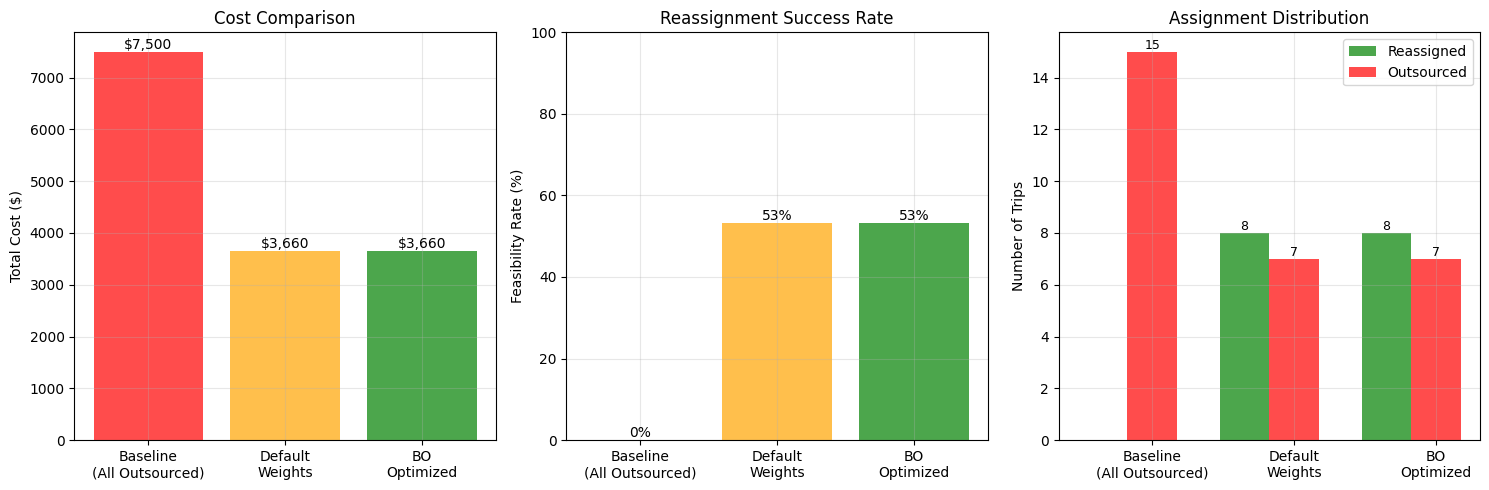

In [26]:

# ============================================================================
# 9. VISUALIZE RESULTS
# ============================================================================

if solution_optimized.metrics:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Cost Comparison
    costs = [
        baseline_metrics.cost.total_cost,
        solution_default.metrics.cost.total_cost if solution_default.metrics else 0,
        solution_optimized.metrics.cost.total_cost
    ]
    labels = ['Baseline\n(All Outsourced)', 'Default\nWeights', 'BO\nOptimized']
    colors = ['red', 'orange', 'green']
    
    axes[0].bar(labels, costs, color=colors, alpha=0.7)
    axes[0].set_ylabel('Total Cost ($)')
    axes[0].set_title('Cost Comparison')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (label, cost) in enumerate(zip(labels, costs)):
        axes[0].text(i, cost, f'${cost:,.0f}', ha='center', va='bottom')
    
    # Plot 2: Feasibility Rate
    feasibility_rates = [
        baseline_metrics.operational.feasibility_rate,
        solution_default.metrics.operational.feasibility_rate if solution_default.metrics else 0,
        solution_optimized.metrics.operational.feasibility_rate
    ]
    
    axes[1].bar(labels, [r*100 for r in feasibility_rates], color=colors, alpha=0.7)
    axes[1].set_ylabel('Feasibility Rate (%)')
    axes[1].set_title('Reassignment Success Rate')
    axes[1].set_ylim([0, 100])
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, rate in enumerate(feasibility_rates):
        axes[1].text(i, rate*100, f'{rate:.0%}', ha='center', va='bottom')
    
    # Plot 3: Assignment Breakdown
    assignment_types = ['Reassigned', 'Outsourced']
    baseline_vals = [0, baseline_metrics.operational.outsourced]
    default_vals = [
        solution_default.metrics.operational.successfully_reassigned if solution_default.metrics else 0,
        solution_default.metrics.operational.outsourced if solution_default.metrics else 0
    ]
    optimized_vals = [
        solution_optimized.metrics.operational.successfully_reassigned,
        solution_optimized.metrics.operational.outsourced
    ]
    
    x = np.arange(len(labels))
    width = 0.35
    
    # Create grouped bars
    bars1 = axes[2].bar(x - width, [baseline_vals[0], default_vals[0], optimized_vals[0]], 
                        width, label='Reassigned', color='green', alpha=0.7)
    bars2 = axes[2].bar(x, [baseline_vals[1], default_vals[1], optimized_vals[1]], 
                        width, label='Outsourced', color='red', alpha=0.7)
    
    axes[2].set_ylabel('Number of Trips')
    axes[2].set_title('Assignment Distribution')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                axes[2].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


In [27]:

# ============================================================================
# 10. KEY INSIGHTS
# ============================================================================

print("\n🎯 KEY INSIGHTS")
print("=" * 50)

if solution_optimized.metrics:
    # Calculate improvements
    cost_reduction = baseline_metrics.cost.total_cost - solution_optimized.metrics.cost.total_cost
    cost_reduction_pct = (cost_reduction / baseline_metrics.cost.total_cost) * 100
    
    print(f"✅ Cost Reduction: ${cost_reduction:,.2f} ({cost_reduction_pct:.1f}%)")
    print(f"✅ Trips Reassigned: {solution_optimized.metrics.operational.successfully_reassigned} "
          f"({solution_optimized.metrics.operational.feasibility_rate:.0%})")
    print(f"✅ Avoided Outsourcing: {baseline_metrics.operational.outsourced - solution_optimized.metrics.operational.outsourced} trips")
    
    if bo_tuner and hasattr(bo_tuner, 'trial_results') and bo_tuner.trial_results:
        print(f"\n📊 Bayesian Optimization Performance:")
        print(f"  • Trials Run: {len(bo_tuner.trial_results)}")
        print(f"  • Best Combined Objective: {min(r.combined_objective for r in bo_tuner.trial_results):.4f}")
        print(f"  • Average Solve Time: {np.mean([r.solve_time_seconds for r in bo_tuner.trial_results]):.2f}s")

print("\n✅ OPTIMIZATION COMPLETE")


🎯 KEY INSIGHTS
✅ Cost Reduction: $3,840.00 (51.2%)
✅ Trips Reassigned: 8 (53%)
✅ Avoided Outsourcing: 8 trips

📊 Bayesian Optimization Performance:
  • Trials Run: 20
  • Best Combined Objective: 0.1816
  • Average Solve Time: 0.02s

✅ OPTIMIZATION COMPLETE


In [ ]:
"""
DYNAMIC TRIP RESCHEDULING WITH BAYESIAN OPTIMIZATION
====================================================
Multi-driver cascading reassignment with CP-SAT and Bayesian Optimization
"""

# ============================================================================
# SETUP
# ============================================================================

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our modules with error handling
try:
    from models.driver_state import DriverState, DailyAssignment
    print("✅ Models imported")
except ImportError as e:
    print(f"❌ Error importing models: {e}")
    raise

try:
    from evaluation_metrics import OptimizationMetrics, MetricsCalculator
    print("✅ Evaluation metrics imported")
except ImportError as e:
    print(f"❌ Error importing evaluation_metrics: {e}")
    raise

try:
    from opt.candidate_gen_v2 import CandidateGeneratorV2
    from opt.cpsat_model_v2 import CPSATOptimizer
    print("✅ Optimization modules imported")
except ImportError as e:
    print(f"❌ Error importing optimization modules: {e}")
    raise

try:
    from opt.bayesian_tuner import BayesianOptimizationTuner
    print("✅ Bayesian tuner imported")
except ImportError as e:
    print(f"⚠️  Warning: Could not import Bayesian tuner: {e}")
    print("   Will use fallback random search")
    BayesianOptimizationTuner = None

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("🚛 DYNAMIC TRIP RESCHEDULING SYSTEM")
print("=" * 50)

# ============================================================================
# 1. LOAD DATA
# ============================================================================

print("\n📊 LOADING DATA")
print("-" * 40)

df_trips = pd.read_csv("../data/processed/trips.csv", parse_dates=['od_start_time', 'od_end_time'])
df_routes = pd.read_csv("../data/processed/routes.csv", parse_dates=['route_start_time', 'route_end_time'])

print(f"✅ Loaded {len(df_trips):,} trips")
print(f"✅ Loaded {len(df_routes):,} routes")
print(f"✅ Date range: {df_trips['od_start_time'].min().date()} to {df_trips['od_start_time'].max().date()}")

# ============================================================================
# 2. INITIALIZE DRIVER STATES
# ============================================================================

print("\n🔧 INITIALIZING DRIVER STATES")
print("-" * 40)

driver_states = {}

# Create DriverState for each unique driver
for _, route in df_routes.iterrows():
    driver_id = route['route_schedule_uuid']
    
    # Get all trips for this driver
    driver_trips = df_trips[df_trips['route_schedule_uuid'] == driver_id].copy()
    
    if len(driver_trips) > 0:
        driver_state = DriverState(driver_id=driver_id, route_id=driver_id)
        
        # Add assignments
        for _, trip in driver_trips.iterrows():
            date_str = trip['od_start_time'].strftime('%Y-%m-%d')
            
            assignment = DailyAssignment(
                trip_id=trip['trip_uuid'],
                start_time=trip['od_start_time'],
                end_time=trip['od_end_time'],
                duration_minutes=int(trip['trip_duration_minutes']),
                start_location=str(trip['source_center']),
                end_location=str(trip['destination_center'])
            )
            
            driver_state.add_assignment(date_str, assignment)
        
        driver_states[driver_id] = driver_state

print(f"✅ Initialized {len(driver_states)} driver states")

# Show driver utilization (with error handling for different DriverState implementations)
try:
    # Try to get utilization summary
    sample_summary = list(driver_states.values())[0].get_utilization_summary() if driver_states else {}
    
    # Check what keys are available and use them
    if 'total_capacity_used_hours' in sample_summary:
        total_capacity_used = sum(d.get_utilization_summary()['total_capacity_used_hours'] 
                                 for d in driver_states.values())
        total_capacity_available = sum(d.get_utilization_summary()['total_days'] * 13 
                                      for d in driver_states.values())
    else:
        # Fallback: calculate from assignments directly
        total_capacity_used = 0
        total_days = 0
        for driver in driver_states.values():
            summary = driver.get_utilization_summary()
            # Use whatever keys are available
            if 'total_hours' in summary:
                total_capacity_used += summary['total_hours']
            elif 'total_minutes' in summary:
                total_capacity_used += summary['total_minutes'] / 60
            
            if 'total_days' in summary:
                total_days += summary['total_days']
            elif 'days_worked' in summary:
                total_days += summary['days_worked']
        
        total_capacity_available = total_days * 13  # 13 hour daily limit
    
    system_utilization = total_capacity_used / total_capacity_available if total_capacity_available > 0 else 0
    
    print(f"📊 System utilization: {system_utilization:.1%}")
    print(f"📊 Available capacity: {total_capacity_available - total_capacity_used:,.0f} hours")
    
except Exception as e:
    print(f"⚠️  Could not calculate system utilization: {e}")
    print(f"📊 Drivers initialized: {len(driver_states)}")

# ============================================================================
# 3. LOAD DISTANCE MATRIX
# ============================================================================

print("\n📍 LOADING DISTANCE MATRIX")
print("-" * 40)

try:
    # Load the distance matrix
    dist_data = np.load("../data/dist_matrix.npz", allow_pickle=True)
    distance_matrix = dist_data['time']  # Travel time matrix
    location_ids = dist_data['ids']  # Location IDs
    
    # Create location mapping from the IDs in the file
    location_to_index = {loc: i for i, loc in enumerate(location_ids)}
    
    print(f"✅ Loaded distance matrix: {distance_matrix.shape}")
    print(f"✅ Number of locations: {len(location_ids)}")
    print(f"📊 Average travel time: {np.mean(distance_matrix[distance_matrix > 0]):.1f} minutes")
    print(f"📊 Max travel time: {np.max(distance_matrix):.1f} minutes")
    
except FileNotFoundError:
    print("⚠️  Distance matrix not found, using default travel times")
    distance_matrix = None
    location_to_index = None

# ============================================================================
# 4. CREATE DISRUPTION SCENARIO
# ============================================================================

print("\n🔥 CREATING DISRUPTION SCENARIO")
print("-" * 40)

# Sample trips to disrupt
np.random.seed(42)  # For reproducibility
n_disruptions = 15
disrupted_trips_df = df_trips.sample(n=n_disruptions)

# Convert to format needed by optimizer
disrupted_trips = []
for _, trip in disrupted_trips_df.iterrows():
    disrupted_trips.append({
        'id': trip['trip_uuid'],
        'start_time': trip['od_start_time'],
        'end_time': trip['od_end_time'],
        'duration_minutes': trip['trip_duration_minutes'],
        'start_location': trip['source_center'],
        'end_location': trip['destination_center']
    })

print(f"✅ Created {len(disrupted_trips)} disrupted trips")
print(f"📊 Total duration: {sum(t['duration_minutes'] for t in disrupted_trips):,.0f} minutes")
print(f"📊 Average duration: {np.mean([t['duration_minutes'] for t in disrupted_trips]):.0f} minutes")

# ============================================================================
# 5. ESTABLISH BASELINE (No Optimization)
# ============================================================================

print("\n📏 BASELINE PERFORMANCE (All Outsourced)")
print("-" * 40)

# Calculate baseline metrics (all trips outsourced)
baseline_metrics = OptimizationMetrics()
baseline_metrics.operational.total_disrupted_trips = len(disrupted_trips)
baseline_metrics.operational.outsourced = len(disrupted_trips)
baseline_metrics.operational.feasibility_rate = 0.0

# Baseline costs (assume $500 per outsourced trip)
outsource_cost_per_trip = 500
baseline_metrics.cost.outsourcing_count = len(disrupted_trips)
baseline_metrics.cost.outsourcing_cost = len(disrupted_trips) * outsource_cost_per_trip
baseline_metrics.cost.total_cost = baseline_metrics.cost.outsourcing_cost

# Baseline SLA (assume outsourcing maintains service but at high cost)
baseline_metrics.sla.total_trips = len(disrupted_trips)
baseline_metrics.sla.on_time_deliveries = len(disrupted_trips)
baseline_metrics.sla.on_time_rate = 1.0

print(f"❌ Feasibility Rate: {baseline_metrics.operational.feasibility_rate:.0%}")
print(f"💰 Total Cost: ${baseline_metrics.cost.total_cost:,.2f}")
print(f"📦 Outsourced Trips: {baseline_metrics.operational.outsourced}/{len(disrupted_trips)}")
print(f"⏱️ On-Time Rate: {baseline_metrics.sla.on_time_rate:.0%}")

# ============================================================================
# 6. RUN CP-SAT OPTIMIZATION (Default Weights)
# ============================================================================

print("\n🧮 RUNNING CP-SAT OPTIMIZATION")
print("-" * 40)

# Initialize optimizer WITH distance matrix
cpsat_optimizer = CPSATOptimizer(
    driver_states,
    distance_matrix=distance_matrix,
    location_to_index=location_to_index
)

# Optionally adjust deadhead limits for more flexibility
# cpsat_optimizer.candidate_generator.max_deadhead_minutes = 180  # 3 hours instead of default 2 hours

# Run with default weights
print("Using default weights: cost=0.4, service=0.3, compliance=0.3")
solution_default = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights={
        'cost_weight': 0.4,
        'service_weight': 0.3,
        'compliance_weight': 0.3
    },
    include_cascades=True,
    max_candidates_per_trip=20
)

# Show improvement over baseline
if solution_default.metrics:
    print(f"\n📈 IMPROVEMENT OVER BASELINE:")
    print(f"  Feasibility: {baseline_metrics.operational.feasibility_rate:.0%} → "
          f"{solution_default.metrics.operational.feasibility_rate:.0%}")
    print(f"  Total Cost: ${baseline_metrics.cost.total_cost:,.2f} → "
          f"${solution_default.metrics.cost.total_cost:,.2f}")
    print(f"  Cost Reduction: ${baseline_metrics.cost.total_cost - solution_default.metrics.cost.total_cost:,.2f} "
          f"({(1 - solution_default.metrics.cost.total_cost/baseline_metrics.cost.total_cost)*100:.1f}%)")

# ============================================================================
# 7. BAYESIAN OPTIMIZATION
# ============================================================================

print("\n🎯 RUNNING BAYESIAN OPTIMIZATION")
print("-" * 40)

if BayesianOptimizationTuner is not None:
    # Initialize BO tuner
    bo_tuner = BayesianOptimizationTuner(
        cpsat_optimizer=cpsat_optimizer,
        optimization_backend='optuna' if 'optuna' in sys.modules else 'random',
        results_dir="bo_results"
    )
    
    # Define parameter search space
    parameter_bounds = {
        'cost_weight': (0.1, 0.7),
        'service_weight': (0.1, 0.6),
        'compliance_weight': (0.1, 0.6),
        'max_cascade_depth': (1, 3)
    }
    
    print("Parameter search space:")
    for param, (low, high) in parameter_bounds.items():
        print(f"  {param}: [{low}, {high}]")
    
    # Run optimization (fewer trials for demo)
    print("\nRunning 20 trials...")
    best_params = bo_tuner.optimize_single_objective(
        disrupted_trips,
        n_trials=20,
        objective='combined',
        parameter_bounds=parameter_bounds
    )
    
    print(f"\n✅ BEST PARAMETERS FOUND:")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.3f}")
        else:
            print(f"  {param}: {value}")
else:
    print("⚠️  Bayesian Optimization not available, using default parameters")
    best_params = {
        'cost_weight': 0.5,
        'service_weight': 0.3,
        'compliance_weight': 0.2,
        'max_cascade_depth': 2
    }
    bo_tuner = None

# ============================================================================
# 8. RUN WITH OPTIMIZED PARAMETERS
# ============================================================================

print("\n🚀 RUNNING WITH OPTIMIZED PARAMETERS")
print("-" * 40)

# Extract weights from best params
optimized_weights = {
    'cost_weight': best_params.get('cost_weight', 0.4),
    'service_weight': best_params.get('service_weight', 0.3),
    'compliance_weight': best_params.get('compliance_weight', 0.3)
}

# Update cascade depth if found
if 'max_cascade_depth' in best_params:
    cpsat_optimizer.candidate_generator.max_cascade_depth = int(best_params['max_cascade_depth'])

# Run with optimized parameters
solution_optimized = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights=optimized_weights,
    include_cascades=True,
    max_candidates_per_trip=20
)

# ============================================================================
# 9. FINAL COMPARISON
# ============================================================================

print("\n📊 FINAL PERFORMANCE COMPARISON")
print("=" * 50)

# Create comparison dataframe
comparison_data = {
    'Metric': [
        'Feasibility Rate (%)',
        'Total Cost ($)',
        'Outsourced Trips',
        'Reassigned Trips',
        'On-Time Rate (%)',
        'Optimization Time (s)'
    ],
    'Baseline (No Opt)': [
        f"{baseline_metrics.operational.feasibility_rate:.0%}",
        f"${baseline_metrics.cost.total_cost:,.2f}",
        baseline_metrics.operational.outsourced,
        0,
        f"{baseline_metrics.sla.on_time_rate:.0%}",
        "N/A"
    ],
    'Default Weights': [
        f"{solution_default.metrics.operational.feasibility_rate:.0%}" if solution_default.metrics else "N/A",
        f"${solution_default.metrics.cost.total_cost:,.2f}" if solution_default.metrics else "N/A",
        solution_default.metrics.operational.outsourced if solution_default.metrics else "N/A",
        solution_default.metrics.operational.successfully_reassigned if solution_default.metrics else "N/A",
        f"{solution_default.metrics.sla.on_time_rate:.0%}" if solution_default.metrics else "N/A",
        f"{solution_default.solve_time_seconds:.1f}"
    ],
    'BO Optimized': [
        f"{solution_optimized.metrics.operational.feasibility_rate:.0%}" if solution_optimized.metrics else "N/A",
        f"${solution_optimized.metrics.cost.total_cost:,.2f}" if solution_optimized.metrics else "N/A",
        solution_optimized.metrics.operational.outsourced if solution_optimized.metrics else "N/A",
        solution_optimized.metrics.operational.successfully_reassigned if solution_optimized.metrics else "N/A",
        f"{solution_optimized.metrics.sla.on_time_rate:.0%}" if solution_optimized.metrics else "N/A",
        f"{solution_optimized.solve_time_seconds:.1f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# ============================================================================
# 10. VISUALIZE RESULTS
# ============================================================================

if solution_optimized.metrics:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Cost Comparison
    costs = [
        baseline_metrics.cost.total_cost,
        solution_default.metrics.cost.total_cost if solution_default.metrics else 0,
        solution_optimized.metrics.cost.total_cost
    ]
    labels = ['Baseline\n(All Outsourced)', 'Default\nWeights', 'BO\nOptimized']
    colors = ['red', 'orange', 'green']
    
    axes[0].bar(labels, costs, color=colors, alpha=0.7)
    axes[0].set_ylabel('Total Cost ($)')
    axes[0].set_title('Cost Comparison')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (label, cost) in enumerate(zip(labels, costs)):
        axes[0].text(i, cost, f'${cost:,.0f}', ha='center', va='bottom')
    
    # Plot 2: Feasibility Rate
    feasibility_rates = [
        baseline_metrics.operational.feasibility_rate,
        solution_default.metrics.operational.feasibility_rate if solution_default.metrics else 0,
        solution_optimized.metrics.operational.feasibility_rate
    ]
    
    axes[1].bar(labels, [r*100 for r in feasibility_rates], color=colors, alpha=0.7)
    axes[1].set_ylabel('Feasibility Rate (%)')
    axes[1].set_title('Reassignment Success Rate')
    axes[1].set_ylim([0, 100])
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, rate in enumerate(feasibility_rates):
        axes[1].text(i, rate*100, f'{rate:.0%}', ha='center', va='bottom')
    
    # Plot 3: Assignment Breakdown
    assignment_types = ['Reassigned', 'Outsourced']
    baseline_vals = [0, baseline_metrics.operational.outsourced]
    default_vals = [
        solution_default.metrics.operational.successfully_reassigned if solution_default.metrics else 0,
        solution_default.metrics.operational.outsourced if solution_default.metrics else 0
    ]
    optimized_vals = [
        solution_optimized.metrics.operational.successfully_reassigned,
        solution_optimized.metrics.operational.outsourced
    ]
    
    x = np.arange(len(labels))
    width = 0.35
    
    # Create grouped bars
    bars1 = axes[2].bar(x - width, [baseline_vals[0], default_vals[0], optimized_vals[0]], 
                        width, label='Reassigned', color='green', alpha=0.7)
    bars2 = axes[2].bar(x, [baseline_vals[1], default_vals[1], optimized_vals[1]], 
                        width, label='Outsourced', color='red', alpha=0.7)
    
    axes[2].set_ylabel('Number of Trips')
    axes[2].set_title('Assignment Distribution')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                axes[2].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 11. KEY INSIGHTS
# ============================================================================

print("\n🎯 KEY INSIGHTS")
print("=" * 50)

if solution_optimized.metrics:
    # Calculate improvements
    cost_reduction = baseline_metrics.cost.total_cost - solution_optimized.metrics.cost.total_cost
    cost_reduction_pct = (cost_reduction / baseline_metrics.cost.total_cost) * 100
    
    print(f"✅ Cost Reduction: ${cost_reduction:,.2f} ({cost_reduction_pct:.1f}%)")
    print(f"✅ Trips Reassigned: {solution_optimized.metrics.operational.successfully_reassigned} "
          f"({solution_optimized.metrics.operational.feasibility_rate:.0%})")
    print(f"✅ Avoided Outsourcing: {baseline_metrics.operational.outsourced - solution_optimized.metrics.operational.outsourced} trips")
    
    if bo_tuner and hasattr(bo_tuner, 'trial_results') and bo_tuner.trial_results:
        print(f"\n📊 Bayesian Optimization Performance:")
        print(f"  • Trials Run: {len(bo_tuner.trial_results)}")
        print(f"  • Best Combined Objective: {min(r.combined_objective for r in bo_tuner.trial_results):.4f}")
        print(f"  • Average Solve Time: {np.mean([r.solve_time_seconds for r in bo_tuner.trial_results]):.2f}s")

print("\n✅ OPTIMIZATION COMPLETE")

✅ Models imported
✅ Evaluation metrics imported
✅ Optimization modules imported
✅ Bayesian tuner imported
🚛 DYNAMIC TRIP RESCHEDULING SYSTEM

📊 LOADING DATA
----------------------------------------
✅ Loaded 14,817 trips
✅ Loaded 1,504 routes
✅ Date range: 2018-09-12 to 2018-10-04

🔧 INITIALIZING DRIVER STATES
----------------------------------------
✅ Initialized 1504 driver states
⚠️  Could not calculate system utilization: 'total_capacity_used_hours'
📊 Drivers initialized: 1504

📍 LOADING DISTANCE MATRIX
----------------------------------------


ValueError: Object arrays cannot be loaded when allow_pickle=False